# Reddit Data Extraction

## Import Libraries

In [15]:
import sys
import pandas as pd
import json
import datetime
import re #regex
import requests #APIs
import praw #reddit API enhanced library
import ffn #stock data
from textblob import TextBlob
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow import keras #lstm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sn
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from pylab import rcParams

import pickle

#!{sys.executable} -m pip install praw
#!{sys.executable} -m pip install textblob
#!{sys.executable} -m pip install ffn
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install pmdarima
# Source: https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/


## Read Data

Read data from previous section

In [2]:
df_wsb = pd.read_csv('pos_neg_sent_wsb_full.csv')

In [3]:
df_stocks = pd.read_csv('pos_neg_sent_stocks_full.csv')

In [4]:
df_kw_stocks = pd.read_csv('df_kw_stocks_full.csv')

In [5]:
df_kw_wsb = pd.read_csv('df_kw_wsb_full.csv')

In [10]:
df_stocks

,date,sentiment score,spy,fourier 5,fourier 10,fourier 15,fourier 20,norm_price,spy log,norm_sentiment,norm_fourier5,norm_fourier10,norm_fourier15,norm_fourier20
0,2018-06-11,2.4699,263.560455,(15.90897701445185-1.210142189036728j),(16.31544095797418-0.6496022104660726j),(16.058128626147653-0.2907215495839383j),(17.753337512516577-0.3766330810178123j),0.229770,NaN,0.100938,0.648821,0.571516,0.527222,0.602785
1,2018-06-12,1.2858,263.901062,(15.523985226100498-1.2030929962845092j),(15.47694651129734-0.6607449472604774j),(14.815572148031643-0.33234091444615227j),(15.941579737995024-0.4032254289850287j),0.231544,0.001291,0.079463,0.634754,0.545306,0.490864,0.550726
2,2018-06-13,0.3503,263.058929,(15.136242092500837-1.1935502095773158j),(14.63472065524542-0.6664125433288913j),(13.575659053045868-0.3677693968853928j),(14.104060023853044-0.4164804520454109j),0.227159,-0.003196,0.062497,0.620586,0.518979,0.454583,0.497927
3,2018-06-14,0.1511,263.721283,(14.746115443044582-1.1815336077978462j),(13.791366797409122-0.6665580351853576j),(12.345659943327387-0.3963470313070807j),(12.263820693502964-0.4159597191465118j),0.230607,0.002515,0.058884,0.606330,0.492618,0.418593,0.445050
4,2018-06-15,0.7227,263.384796,(14.353974051856829-1.1670680971882976j),(12.949487439525027-0.6611802172385295j),(11.132742199146278-0.41754147045289797j),(10.444112051688242-0.4016804543604311j),0.228855,-0.001277,0.069250,0.592001,0.466302,0.383102,0.392762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,2021-04-05,35.8456,406.359985,(17.779921814670278-1.2076551611997206j),(20.36242197943935-0.5165278335885646j),(22.05784088772455-0.020074074903710173j),(25.694606748856636-0.08783812412013642j),0.973289,0.014251,0.706239,0.717186,0.698017,0.702776,0.830969
686,2021-04-06,25.8704,406.119995,(17.414135620095113-1.2131888957093853j),(19.58074525184743-0.5527883868923636j),(20.909761430318955-0.07925479611578258j),(24.316499852755875-0.1603944668516503j),0.972040,-0.000591,0.525329,0.703820,0.673584,0.669183,0.791371
687,2021-04-07,30.9270,406.589996,(17.043790848689707-1.2162081109708092j),(18.78276634034733-0.5844683615288923j),(19.728905629065967-0.13695915043205176j),(22.817073836129858-0.22764550648498505j),0.974487,0.001157,0.617035,0.690288,0.648640,0.634630,0.748286
688,2021-04-08,41.9974,408.519989,(16.669243009018825-1.2167065491993059j),(17.970897055633845-0.6113052472511153j),(18.52200269927605-0.19211221491243521j),(21.211415076026192-0.2873668075023479j),0.984536,0.004736,0.817808,0.676602,0.623263,0.599316,0.702149


## Collect All Stock Data

In [6]:
spy=ffn.get('spy', start='2010-01-01')

In [8]:
spy

,spy
Date,
2010-01-04,90.790062
2010-01-05,91.030411
2010-01-06,91.094490
2010-01-07,91.479050
2010-01-08,91.783432
...,...
2021-04-12,411.640015
2021-04-13,412.859985
2021-04-14,411.450012


## Test for Stationarity

In [13]:

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)



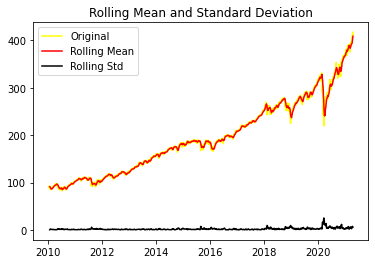

Results of dickey fuller test
Test Statistics                   1.643366
p-value                           0.997982
No. of lags used                 27.000000
Number of observations used    2813.000000
critical value (1%)              -3.432677
critical value (5%)              -2.862568
critical value (10%)             -2.567317
dtype: float64


In [11]:
test_stationarity(spy['spy'])

Since the p-value is > 0.05, we accept the null hypothesis and conclude that the data is non-stationary. 

## Trend and Seasonality

<ipython-input-14-f21c50791902>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(spy, model='multiplicative', freq = 30)


<Figure size 432x288 with 0 Axes>

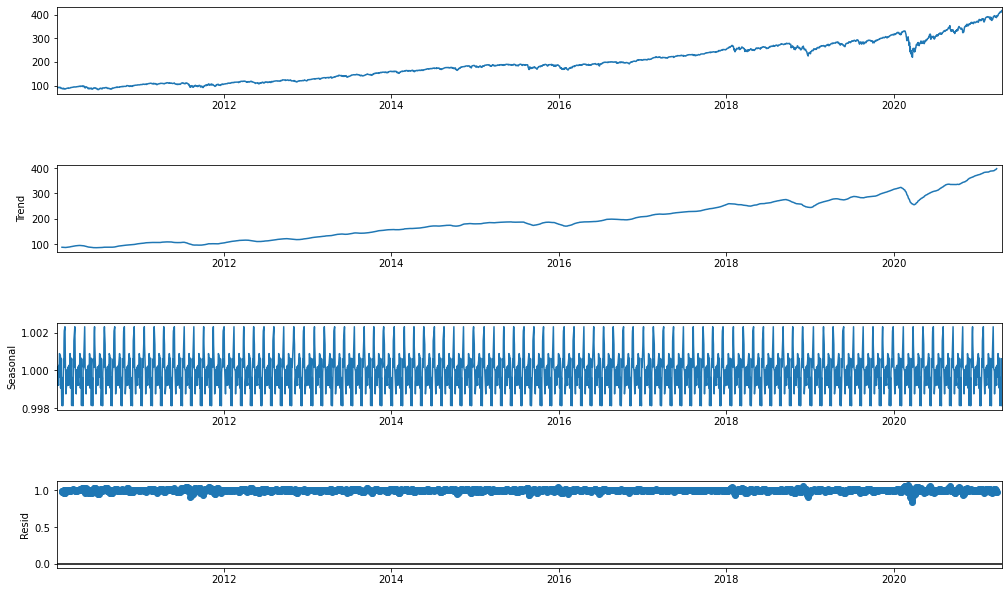

In [14]:
result = seasonal_decompose(spy, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [41]:
spy

,spy
Date,
2010-01-04,90.790062
2010-01-05,91.030411
2010-01-06,91.094490
2010-01-07,91.479050
2010-01-08,91.783432
...,...
2021-04-12,411.640015
2021-04-13,412.859985
2021-04-14,411.450012


In [42]:
spy_log

Date
2010-01-04    4.508550
2010-01-05    4.511194
2010-01-06    4.511897
2010-01-07    4.516110
2010-01-08    4.519432
                ...   
2021-04-12    6.020149
2021-04-13    6.023109
2021-04-14    6.019688
2021-04-15    6.030373
2021-04-16    6.033710
Name: spy, Length: 2841, dtype: float64

No handles with labels found to put in legend.


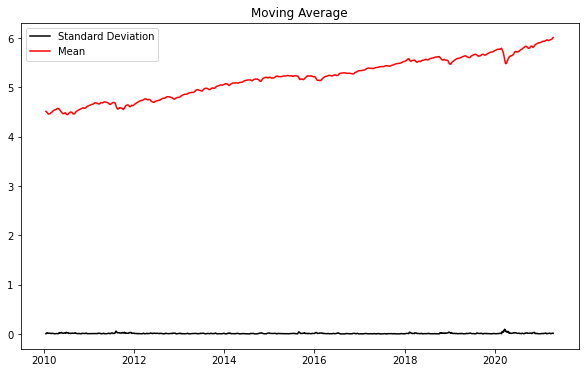

In [22]:
rcParams['figure.figsize'] = 10, 6
spy_log = np.log(spy['spy'])
moving_avg = spy_log.rolling(12).mean()
std_dev = spy_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [34]:
spy_log

Date
2010-01-04    4.508550
2010-01-05    4.511194
2010-01-06    4.511897
2010-01-07    4.516110
2010-01-08    4.519432
                ...   
2021-04-12    6.020149
2021-04-13    6.023109
2021-04-14    6.019688
2021-04-15    6.030373
2021-04-16    6.033710
Name: spy, Length: 2841, dtype: float64

In [38]:
spylog = pd.DataFrame(spy_log)

In [39]:
spylog

,spy
Date,
2010-01-04,4.508550
2010-01-05,4.511194
2010-01-06,4.511897
2010-01-07,4.516110
2010-01-08,4.519432
...,...
2021-04-12,6.020149
2021-04-13,6.023109
2021-04-14,6.019688


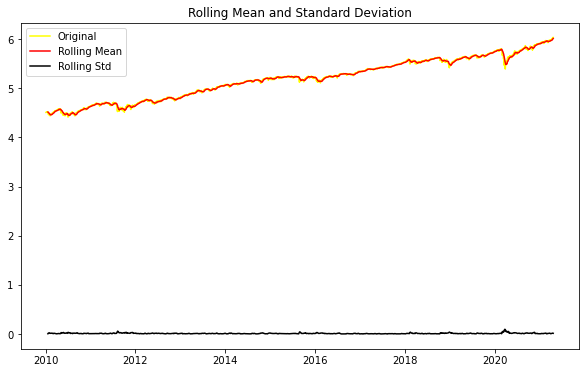

Results of dickey fuller test
Test Statistics                  -0.054058
p-value                           0.953827
No. of lags used                 27.000000
Number of observations used    2813.000000
critical value (1%)              -3.432677
critical value (5%)              -2.862568
critical value (10%)             -2.567317
dtype: float64


In [40]:
test_stationarity(spylog['spy'])

## Split Train and Test Data

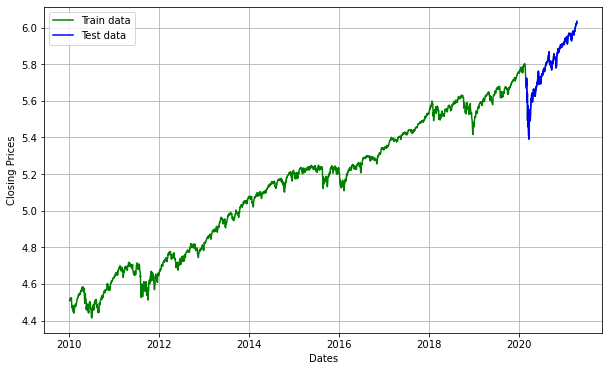

In [23]:
train_data, test_data = spy_log[3:int(len(spy_log)*0.9)], spy_log[int(len(spy_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## ARIMA Model

In [24]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15600.644, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-16598.439, Time=1.59 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-16555.153, Time=1.62 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-16597.088, Time=2.00 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.66 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-16600.605, Time=0.46 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1231.096, Time=0.77 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-16600.801, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-16598.712, Ti

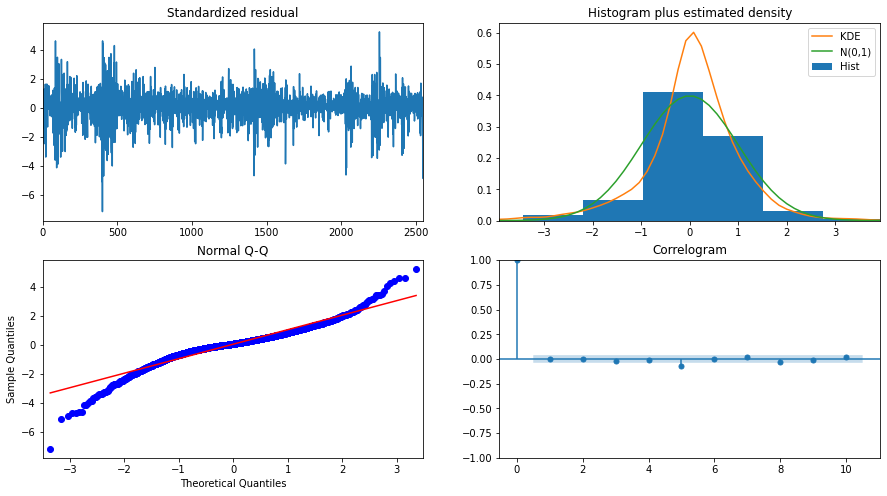

In [27]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [28]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

C:\Users\P2773714\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\P2773714\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated fre

                             ARIMA Model Results                              
Dep. Variable:                  D.spy   No. Observations:                 2552
Model:                 ARIMA(3, 1, 2)   Log Likelihood                8316.180
Method:                       css-mle   S.D. of innovations              0.009
Date:                Fri, 16 Apr 2021   AIC                         -16618.361
Time:                        19:01:03   BIC                         -16577.448
Sample:                             1   HQIC                        -16603.523
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005   6.78e-05      7.101      0.000       0.000       0.001
ar.L1.D.spy     0.2743      0.210      1.309      0.191      -0.136       0.685
ar.L2.D.spy     0.6959      0.194      3.580    

In [29]:
## Forecast Data

In [32]:
fc, se, conf = fitted.forecast(285, alpha=0.05)  # 95% confidence

In [145]:
fc

array([5.67004251, 5.67242871, 5.6735571 , 5.67554027, 5.67686034,
       5.67860883, 5.68000288, 5.68160601, 5.68301456, 5.68451959,
       5.68591312, 5.68734559, 5.68870997, 5.69008414, 5.69141314,
       5.6927374 , 5.6940288 , 5.69530845, 5.69656206, 5.69780077,
       5.69901742, 5.70021796, 5.70139892, 5.70256356, 5.70371031,
       5.70484104, 5.70595511, 5.7070537 , 5.70813664, 5.70920472,
       5.71025803, 5.71129714, 5.71232226, 5.71333384, 5.71433215,
       5.71531756, 5.71629038, 5.71725093, 5.7181995 , 5.71913641,
       5.72006194, 5.72097637, 5.72187999, 5.72277306, 5.72365585,
       5.72452862, 5.72539161, 5.72624507, 5.72708923, 5.72792433,
       5.7287506 , 5.72956825, 5.73037751, 5.73117857, 5.73197165,
       5.73275695, 5.73353465, 5.73430495, 5.73506804, 5.73582409,
       5.73657328, 5.73731578, 5.73805176, 5.73878138, 5.7395048 ,
       5.74022217, 5.74093365, 5.74163938, 5.74233951, 5.74303418,
       5.74372352, 5.74440766, 5.74508674, 5.74576088, 5.74643

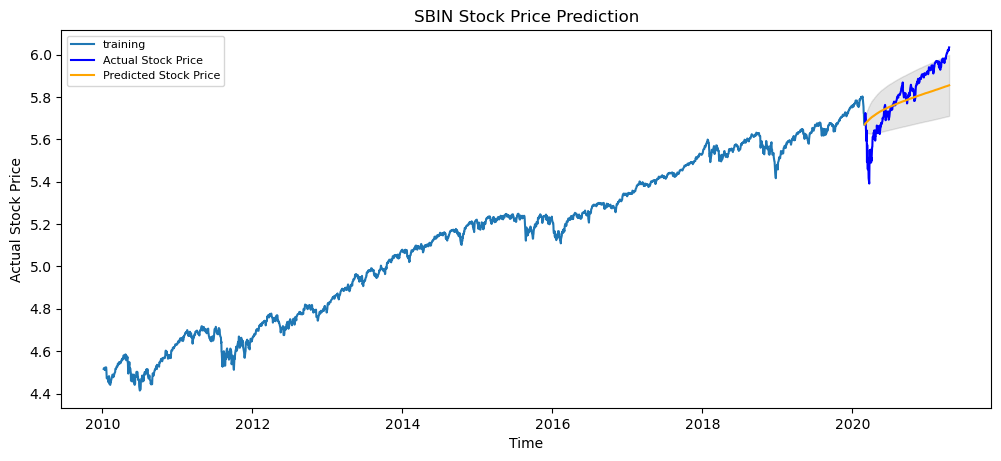

In [33]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [141]:
print('MAE: ', sum(tf.keras.metrics.mean_absolute_error(test_data, fc_series).numpy())/len(test_data))

MAE:  0.07712153783193099


In [144]:
test_data

,spy
Date,
2020-03-02,5.711860
2020-03-03,5.682810
2020-03-04,5.723983
2020-03-05,5.690177
2020-03-06,5.673507
...,...
2021-04-12,6.020149
2021-04-13,6.023109
2021-04-14,6.019688


## Evaluate Results

Identify optimal buying points. Invest in the lowest predicted day of each week and sell at the end. Then, compare to a buy-and-hold strategy, where investment is randomly on the same number of days. 



In [46]:
#Convert forcasted data and test data to dataframes, then merge into one dataframe
fc_series = pd.DataFrame(fc_series)
test_data = pd.DataFrame(test_data)
df_pred = pd.merge(test_data,fc_series,left_on='Date',right_on='Date',how='inner')

#Rename columns
df_pred.columns.values[0] = "spy_actual"
df_pred.columns.values[1] = "spy_pred"

df_pred = pd.DataFrame(df_pred)
df_pred.reset_index(drop=False, inplace=True)

#Add weekday column for aggregation
df_pred["weekday"] = pd.to_datetime(df_pred.Date).dt.dayofweek

#Minimum predicted stock prices per week
min_week_values = df_pred.groupby([pd.Grouper(key='Date', freq='W-MON')])['spy_pred'].min()
#Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

#Dataset for all of the predicted low stock price dates per week
min_dates = pd.merge(df_pred,min_week_values,left_on='spy_pred',right_on='spy_pred',how='inner')

#Number of purchase days
num_days = min_dates['Date'].count()

#Pick random dates to purchase for comparison
rand_dates = df_pred.sample(n = num_days)

#Cost using predicted purchase dates
pred_cost = (min_dates['spy_actual'] * 10).sum()

#Cost using random purchase dates
rand_cost = (rand_dates['spy_actual'] * 10).sum()

In [138]:
rand_cost

3492.6715795311097

In [139]:
pred_cost

3482.6637798391926

In [136]:
adj_dollars_diff = rand_cost - pred_cost

In [137]:
adj_dollars_diff

10.007799691917171

Using the predicted cost ends up saving 10 dollars unadjusted, which equates to around 2 shares, or 800 dollars adjusted!

Sources: 


https://www.reddit.com/dev/api/

https://praw.readthedocs.io/en/latest/index.html

In [25]:
#Source: https://www.analyticsvidhya.com/blog/2020/11/stock-market-price-trend-prediction-using-time-series-forecasting/